In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\VSIE43\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_pth = r'C:\Users\VSIE43\OneDrive - Scania CV\Thesis\SKAB-master\data/'
normal_file = 'anomaly-free/anomaly-free.csv'
test_1 = 'other'
test_2 = 'valve1'
test_3 = 'valve2'

df = pd.read_csv(data_pth+normal_file, sep=';')

df.columns

def fillin_time_gaps(df):
    df.datetime = pd.to_datetime(df.datetime.values)
    time_diff = np.diff(df.datetime.values)

    # there will be need for data imputation. 
    # some samples are with differnce of 2 seconds, rather than 1 second
    new_time = pd.date_range(df.datetime.min(), df.datetime.max(),freq='1s')
    missing_time = pd.DataFrame({'datetime' : new_time})
    df_new = missing_time.merge(df, on='datetime', how='left')

    # maybe fill in with interpolation
    df_new = df_new.interpolate(method='ffill')
    return df_new

normal_data = []
df = pd.read_csv(data_pth+normal_file, sep=';')
normal_data.append(fillin_time_gaps(df).drop(columns=['datetime']))
for folder in [test_2, test_3]:
    files = os.listdir(data_pth+folder)
    print(files)
    for file in files:
        tmp = pd.read_csv(data_pth+folder+'/'+file, sep=';')
        # print(tmp.columns)
        # t = tmp[tmp.anomaly==1]
        t=tmp[tmp.anomaly==0]
        t = t.drop(columns=['changepoint'])
        normal_data.append(t)

df = fillin_time_gaps(df)

['0.csv', '1.csv', '10.csv', '11.csv', '12.csv', '13.csv', '14.csv', '15.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv']
['0.csv', '1.csv', '2.csv', '3.csv']


In [3]:
def min_max_normalize(df, m_m_params=None):
    
    if m_m_params:
        (min_p, max_p) = m_m_params
    else:
        (min_p, max_p) = df.min(), df.max()

    new_df = (df-min_p) / (max_p-min_p)

    return new_df,  (min_p, max_p)


data, m_m_params = min_max_normalize(df.drop(columns=['datetime']))

test_df_1 = pd.read_csv(data_pth+test_1+'/5.csv',sep=';')
test_df_1_norm, _  = min_max_normalize(test_df_1.drop(columns=['datetime','anomaly','changepoint']), m_m_params)

# Enable synchronous error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Function to create temporal node features
def create_temporal_features(df):
    features = []
    for t in range(len(df)):
        x_t = torch.tensor(df.iloc[t].values, dtype=torch.float).view(-1, 1)
        features.append(x_t)
    return features

# Create temporal node features for training, validation, and testing
temporal_features_train = create_temporal_features(data)
# temporal_features_val = create_temporal_features(val_data)
temporal_features_test = create_temporal_features(test_df_1_norm)

def create_sliding_windows(features, window_size, stride):
    windows = []

    for i in range(0, len(features) - window_size, stride):
        window = features[i:i + window_size]
        
        windows.append(window)

    return np.array(windows)

# Example usage
window_size = 16  # Define your window size
stride = 1  # Define the stride for the sliding window

# Create sliding windows for training, validation, and testing
temporal_windows_train = create_sliding_windows(temporal_features_train, window_size, stride)
# temporal_windows_val, temporal_windows_val_next_step = create_sliding_windows(temporal_features_val, window_size, stride)
temporal_windows_test = create_sliding_windows(temporal_features_test, window_size, stride)

class TimeSeriesDataset(Dataset):
    def __init__(self, windows, next_step_t):
        self.windows = windows
        self.next_step_t = next_step_t

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        next_step_window = self.next_step_t[idx]
        return window, next_step_window

# Check if CUDA is available and set the device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move edge_index to the GPU
num_nodes = len(data.columns)

# Fully Connected Graph with Self Connections
# edge_index = torch.tensor([(i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous().to(device)

# Fully Connected Graph without self connections
edge_index = torch.tensor([(i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.int64).t().contiguous()

# Create dataset objects
train_dataset = TimeSeriesDataset(temporal_windows_train, temporal_windows_train)
# val_dataset = TimeSeriesDataset(temporal_windows_val, temporal_windows_val_next_step)
test_dataset = TimeSeriesDataset(temporal_windows_test, temporal_windows_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last= False)

temporal_windows_train shape: (9945, 16, 8, 1)
temporal_windows_train_next_step shape: (9945, 16, 8, 1)
temporal_windows_test shape: (1139, 16, 8, 1)
temporal_windows_test_next_step shape: (1139, 16, 8, 1)


In [4]:
print(edge_index.shape)

torch.Size([2, 56])


In [5]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, embedding_dim, out_channels):
        super(GCN, self).__init__()
        # Initial GCN Layers
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, embedding_dim)
        
        # Final GCN Layers
        self.final_gcn1 = GCNConv(embedding_dim, hidden_channels)
        self.final_gcn2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        batch_size, sequence_length, num_nodes = x.size()
        gcn_outputs = []

        for t in range(sequence_length):
            gcn_output = self.gcn1(x[:, t, :], edge_index)
            gcn_output = F.relu(gcn_output)
            gcn_output = self.gcn2(gcn_output, edge_index)
            gcn_output = F.relu(gcn_output)
            gcn_outputs.append(gcn_output.view(batch_size, 1, -1))  # Shape: [batch_size, 1, embedding_dim]

        gcn_outputs = torch.cat(gcn_outputs, dim=1)  # Shape: [batch_size, sequence_length, embedding_dim]

        return gcn_outputs

    def forward_final(self, x, edge_index):
        batch_size, sequence_length, embedding_dim = x.size()
        gcn_outputs = []

        for t in range(sequence_length):
            gcn_output = self.final_gcn1(x[:, t, :], edge_index)
            gcn_output = F.relu(gcn_output)
            gcn_output = self.final_gcn2(gcn_output, edge_index)
            gcn_output = F.relu(gcn_output)
            gcn_outputs.append(gcn_output.view(batch_size, 1, -1))  # Shape: [batch_size, 1, out_channels]

        gcn_outputs = torch.cat(gcn_outputs, dim=1)  # Shape: [batch_size, sequence_length, out_channels]

        return gcn_outputs
    

class Autoencoder(nn.Module):
    def __init__(self, embedding_dim, hidden_channels):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, embedding_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z
    

class GCN_Autoencoder_GCN(nn.Module):
    def __init__(self, gcn, autoencoder):
        super(GCN_Autoencoder_GCN, self).__init__()
        self.gcn = gcn
        self.autoencoder = autoencoder

    def forward(self, data, edge_index):
        # Initial GCN
        x = self.gcn(data, edge_index)
        
        # Autoencoder
        x_reconstructed, z = self.autoencoder(x)
        
        # Final GCN
        x = self.gcn.forward_final(x_reconstructed, edge_index)
        
        return x, x_reconstructed, z

In [6]:
in_channels = num_nodes  # Number of input features per node
hidden_channels = 64  # Hidden dimension for GCN layers and Autoencoder
embedding_dim = 32  # Embedding dimension
out_channels = num_nodes  # Number of output features per node

# Initialize the components
gcn = GCN(in_channels, hidden_channels, embedding_dim, out_channels)
autoencoder = Autoencoder(embedding_dim, hidden_channels)
model = GCN_Autoencoder_GCN(gcn, autoencoder)

In [7]:
criterion = nn.MSELoss()
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.001)
optimizer_ae = torch.optim.Adam(model.autoencoder.parameters(), lr=0.001)

Epoch 1/10, GCN Loss: 0.21586994683052566
Epoch 2/10, GCN Loss: 0.2052501511439633
Epoch 3/10, GCN Loss: 0.17286176397390304
Epoch 4/10, GCN Loss: 0.16938863831221865
Epoch 5/10, GCN Loss: 0.16887147681506118
Epoch 6/10, GCN Loss: 0.16841566768681504
Epoch 7/10, GCN Loss: 0.1680605521491486
Epoch 8/10, GCN Loss: 0.16784229469740122
Epoch 9/10, GCN Loss: 0.16778041585273681
Epoch 10/10, GCN Loss: 0.16772842591694315


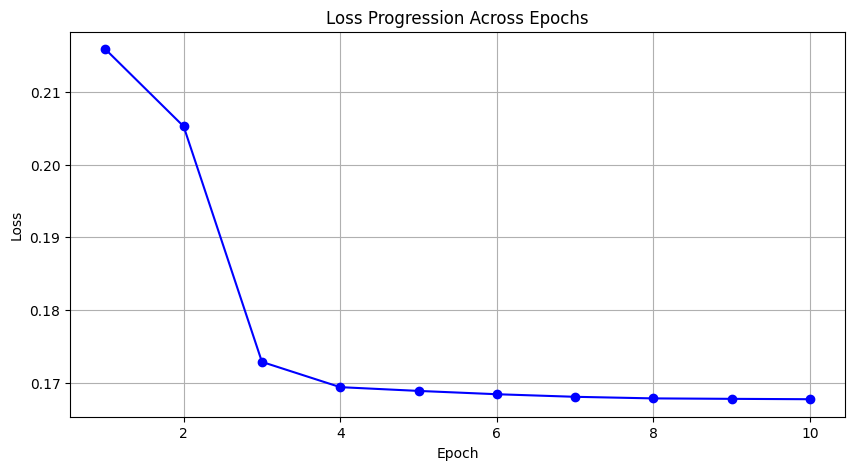

In [8]:
import matplotlib.pyplot as plt

def train_gcn(model, train_loader, optimizer, criterion, edge_index, num_epochs=10):
    model.train()
    loss_values = []  # List to store loss values for each epoch

    for epoch in range(num_epochs):
        total_loss = 0
        for windows, target in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            gcn_output = model.forward(windows.squeeze(), edge_index)
            final_output = model.forward_final(gcn_output, edge_index)
            
            # Calculate the loss
            loss = criterion(final_output, target.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        average_loss = total_loss / len(train_loader)
        loss_values.append(average_loss)  # Store the average loss for this epoch
        print(f"Epoch {epoch+1}/{num_epochs}, GCN Loss: {average_loss}")

    # Plotting the loss values
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
    plt.title('Loss Progression Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Example usage (assuming the model and other variables are already defined)
train_gcn(gcn, train_loader, optimizer_gcn, criterion, edge_index)

In [9]:
def freeze_gcn_parameters(model):
    for param in model.gcn.parameters():
        param.requires_grad = False

freeze_gcn_parameters(model)

Epoch 1/10, Autoencoder Loss: 0.07396273228708188
Epoch 2/10, Autoencoder Loss: 0.06506455514783645
Epoch 3/10, Autoencoder Loss: 0.0638949676533604
Epoch 4/10, Autoencoder Loss: 0.06436317338581254
Epoch 5/10, Autoencoder Loss: 0.062169984198651516
Epoch 6/10, Autoencoder Loss: 0.061829879077396975
Epoch 7/10, Autoencoder Loss: 0.061555852676319536
Epoch 8/10, Autoencoder Loss: 0.06142464269347896
Epoch 9/10, Autoencoder Loss: 0.06097942593109186
Epoch 10/10, Autoencoder Loss: 0.06092909404894163


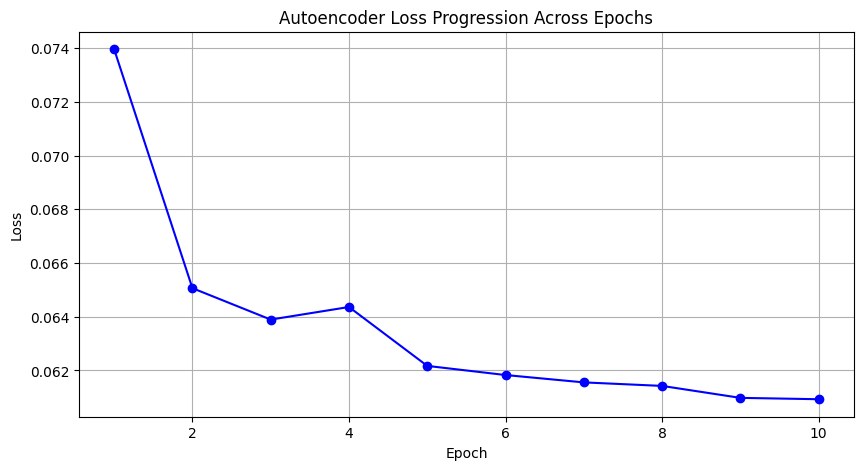

In [10]:
def train_autoencoder(model, train_loader, optimizer, criterion, edge_index, num_epochs=10):
    model.train()
    loss_values = []  # List to store loss values for each epoch

    for epoch in range(num_epochs):
        total_loss = 0
        for windows, target in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            with torch.no_grad():
                gcn_output = model.gcn.forward(windows.squeeze(), edge_index)
            
            x_reconstructed, z = model.autoencoder(gcn_output)
            
            final_output = model.gcn.forward_final(x_reconstructed, edge_index)
            
            # Calculate the loss
            loss = criterion(final_output, target.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        average_loss = total_loss / len(train_loader)
        loss_values.append(average_loss)  # Store the average loss for this epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Autoencoder Loss: {average_loss}")

    # Plotting the loss values
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
    plt.title('Autoencoder Loss Progression Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Example usage (assuming the model and other variables are already defined)
train_autoencoder(model, train_loader, optimizer_ae, criterion, edge_index)

In [11]:
actual_values = []
predicted_values = []
model.eval()
with torch.no_grad():
    for windows, target in train_loader:
        # sequences = sequences.squeeze(-1).to(device)
        windows = windows.squeeze(-1)
        # labels = labels.squeeze(-1).to(device)
        target = target.squeeze(-1)
        gcn_output = model.gcn.forward(windows, edge_index)
        x_reconstructed, z = model.autoencoder(gcn_output)
        final_output = model.gcn.forward_final(x_reconstructed, edge_index)
        actual_values.extend(target)
        predicted_values.extend(final_output)

In [12]:
np.array(predicted_values).shape

(9945, 16, 8)

(array([  16.,   88.,  317.,  922., 1938., 2512., 2426., 1281.,  377.,
          68.]),
 array([0.16948473, 0.18533683, 0.20118892, 0.217041  , 0.23289309,
        0.24874519, 0.26459727, 0.28044936, 0.29630145, 0.31215355,
        0.32800564]),
 <BarContainer object of 10 artists>)

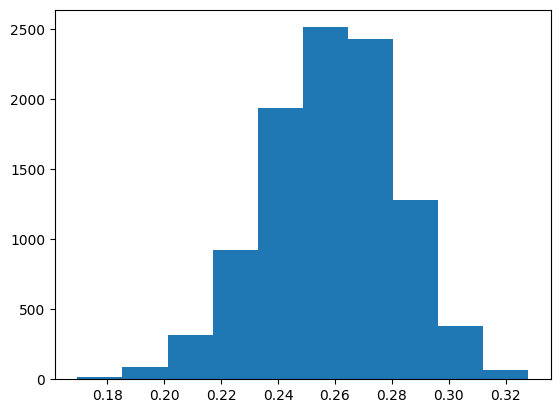

In [13]:
residual_train = np.sqrt(np.mean((np.array(predicted_values)-np.array(actual_values))**2, axis=(1,2)))
plt.hist(residual_train)

(array([  16.,   88.,  317.,  922., 1938., 2512., 2426., 1281.,  377.,
          68.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

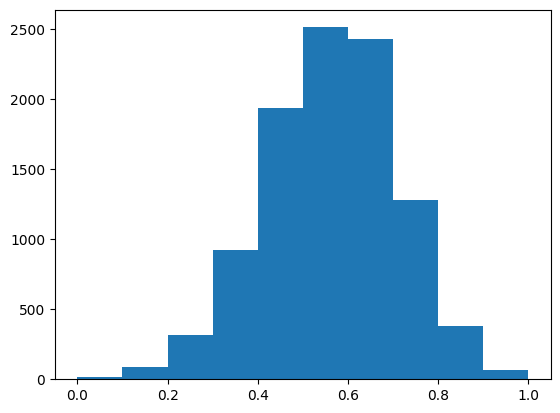

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_residual = scaler.fit_transform(residual_train.reshape(-1, 1))
plt.hist(scaled_residual)

In [15]:
threshold = np.percentile(scaled_residual, 70)
threshold

0.6435230731964111

In [16]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

def inference(test_loader, model, edge_index):
    model.eval()
    epoch_losses = []  # List to store loss values for each epoch
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for epoch in range(1):
            total_loss = 0
            epoch_preds = []
            epoch_targets = []

            for batch in tqdm(test_loader, desc=f"Inference Batches Epoch {epoch + 1}", leave=False):
                windows, target = batch

                # Remove the extra dimension
                windows = windows.squeeze(-1)
                target = target.squeeze(-1)

                # Forward pass through GCN
                gcn_output = model.gcn.forward(windows, edge_index)

                # Pass through Autoencoder
                x_reconstructed, z = model.autoencoder(gcn_output)

                # Final forward pass through GCN
                final_preds = model.gcn.forward_final(x_reconstructed, edge_index)

                # Compute loss
                loss = F.mse_loss(final_preds, target)
                total_loss += loss.item()

                # Collect predictions and targets for this epoch
                epoch_preds.append(final_preds.cpu().numpy())
                epoch_targets.append(target.cpu().numpy())

            average_loss = total_loss / len(test_loader)
            epoch_losses.append(average_loss)  # Store the average loss for this epoch
            print(f"Epoch {epoch + 1}/{num_epochs}, Inference Loss: {average_loss}")

            # Concatenate predictions and targets for this epoch
            all_predictions.append(np.concatenate(epoch_preds, axis=0))
            all_targets.append(np.concatenate(epoch_targets, axis=0))

    # Concatenate all predictions and targets across all epochs
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Plotting the loss values
    # plt.figure(figsize=(10, 5))
    # plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
    # plt.title('Inference Loss Progression Across Epochs')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.grid(True)
    # plt.show()

    return epoch_losses, all_predictions, all_targets

# Example usage
num_epochs = 10  # Define the number of epochs for inference
test_losses, final_preds, targets = inference(test_loader, model, edge_index)
print(f'Test Losses across epochs: {test_losses}')


Epoch 1/10, Inference Loss: 7.845352673282226
Test Losses across epochs: [7.845352673282226]


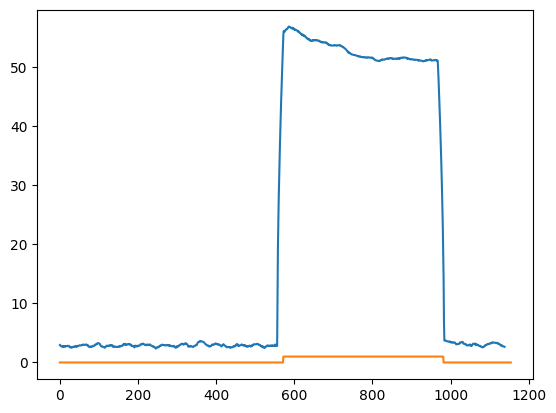

In [17]:
residual_test = np.sqrt(np.sum((final_preds-targets)**2, axis=(1,2)))

plt.plot(residual_test)
plt.plot(test_df_1.anomaly)

In [18]:
dtype = torch.float32

preds = []
labels_tmp = []
file_number = []
residual_tmp_all = []

files = os.listdir(data_pth + test_1)
model.eval()
print(files)
for file in files:
    print(file)
    tmp_actual = []
    tmp_pred = []
    tmp = pd.read_csv(data_pth + test_1 + '/' + file, sep=';')

    t = tmp.anomaly.values
    test_df_1_tmp, _ = min_max_normalize(tmp.drop(columns=['datetime', 'anomaly', 'changepoint']), m_m_params)
    temporal_windows_tmp, temporal_windows_tmp_next_step = create_sliding_windows(test_df_1_tmp, window_size=16, stride=1)
    tmp_dataset = TimeSeriesDataset(temporal_windows_tmp, temporal_windows_tmp_next_step)
    tmp_loader = DataLoader(tmp_dataset, batch_size=64, shuffle=False)

    actual_values = []
    predicted_values = []

    with torch.no_grad():
        for windows, target in tmp_loader:
            windows = windows.squeeze(-1).type(dtype)
            target = target.squeeze(-1).type(dtype)

            gcn_output = model.gcn.forward(windows, edge_index)
            x_reconstructed, z = model.autoencoder(gcn_output)
            final_output = model.gcn.forward_final(x_reconstructed, edge_index)

            actual_values.extend(target.numpy())
            predicted_values.extend(final_output.numpy())

    residual_tmp = np.sqrt(np.sum((np.array(predicted_values) - np.array(actual_values)) ** 2, axis=(1, 2)))

    residual_tmp_all.append(residual_tmp)
    labels_tmp.append(t[-len(predicted_values):])
    i = int(file.split('.')[0])
    file_number.append([i] * len(predicted_values))
    preds.append(residual_tmp>4)
    # i +=1
    
preds = np.concatenate(preds, axis=0)
labels = np.concatenate(labels_tmp, axis=0)
file_number = np.concatenate(file_number, axis=0)

['1.csv', '10.csv', '11.csv', '12.csv', '13.csv', '14.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv']
1.csv
10.csv
11.csv
12.csv
13.csv
14.csv
2.csv
3.csv
4.csv
5.csv
6.csv
7.csv
8.csv
9.csv


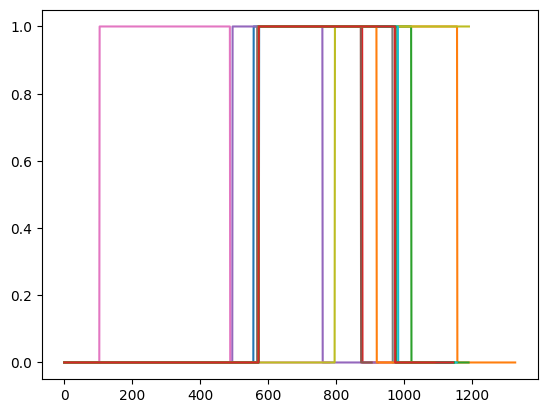

In [19]:
tmp_anom_list = []
for file in files:
    tmp_df = pd.read_csv(data_pth+test_1+'/'+file, sep=';')
    tmp_anom_list.append(tmp_df.anomaly)
    plt.plot(tmp_df.anomaly)

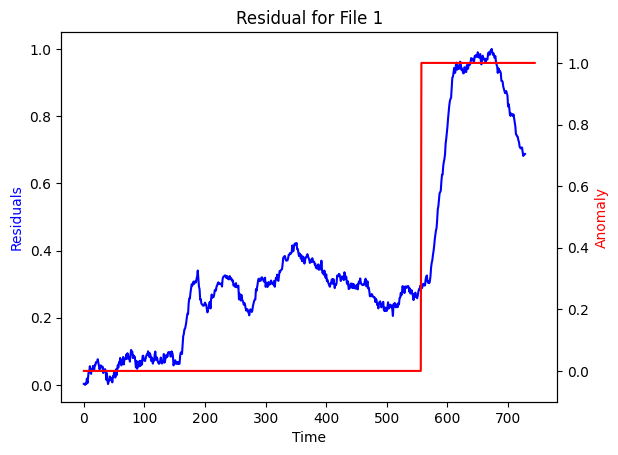

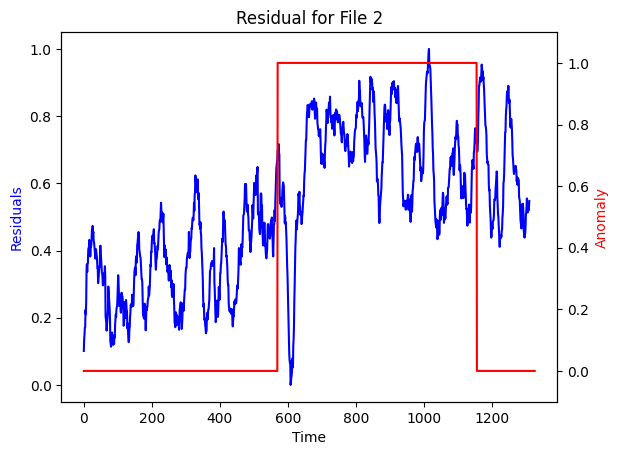

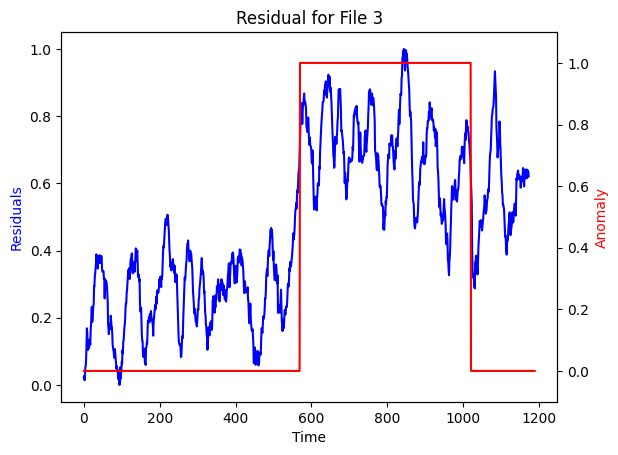

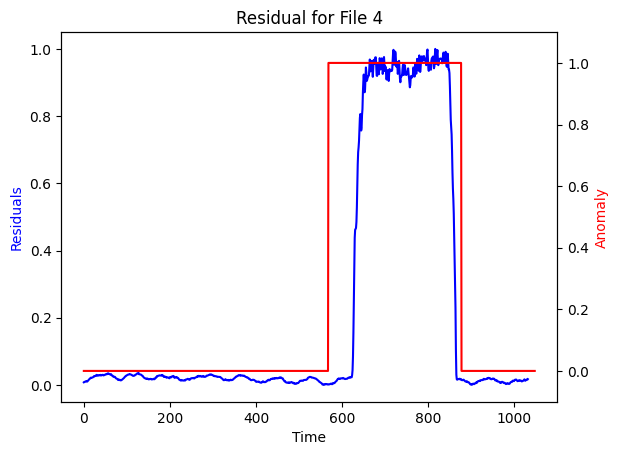

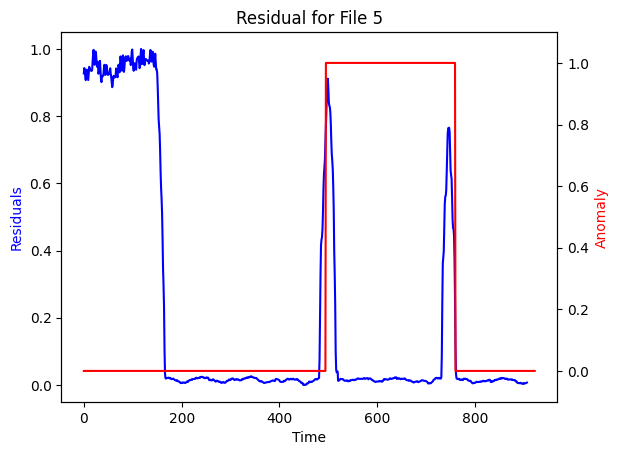

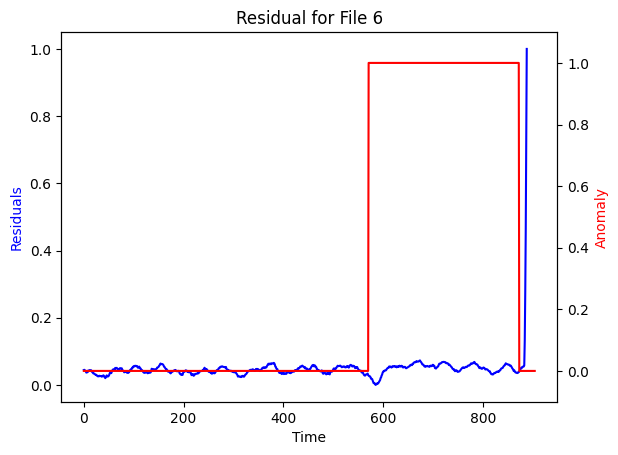

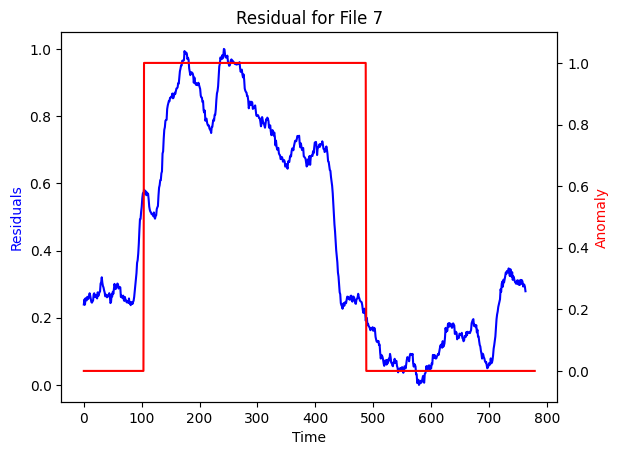

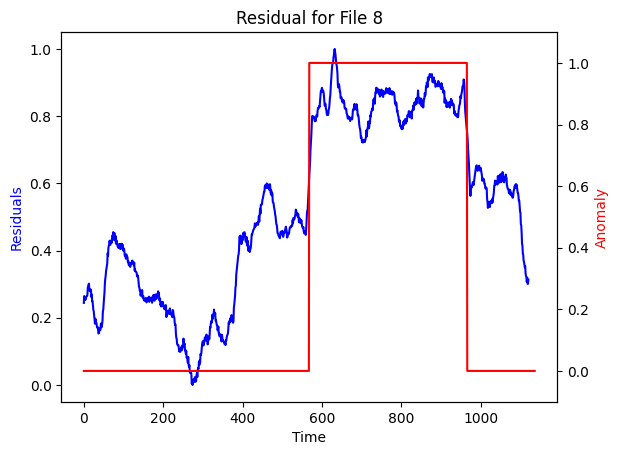

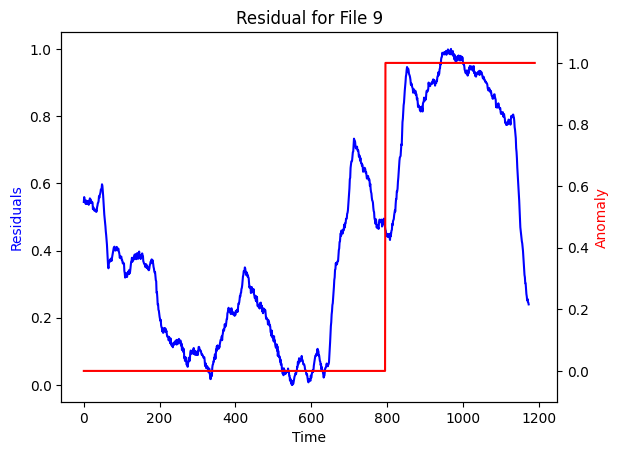

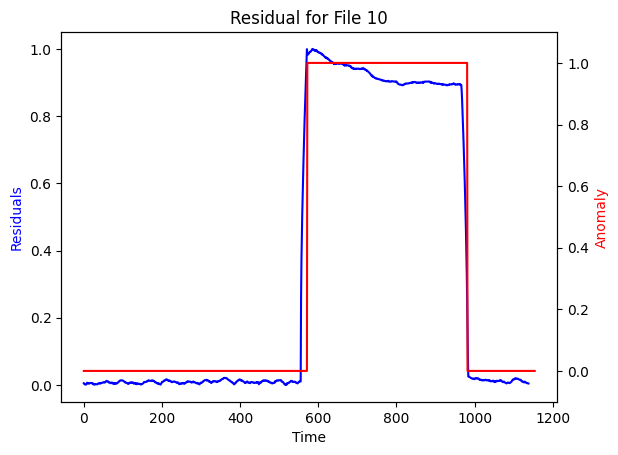

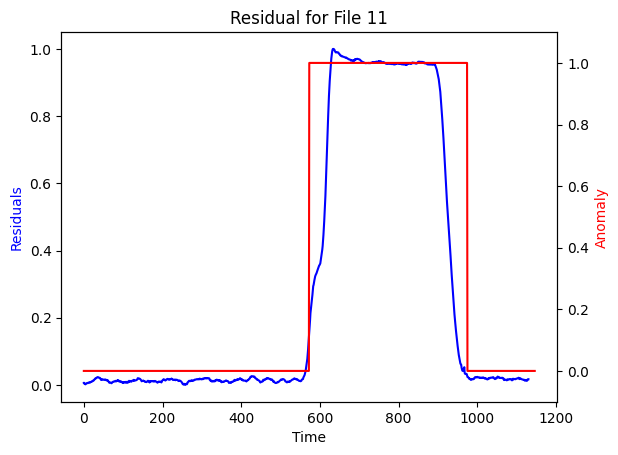

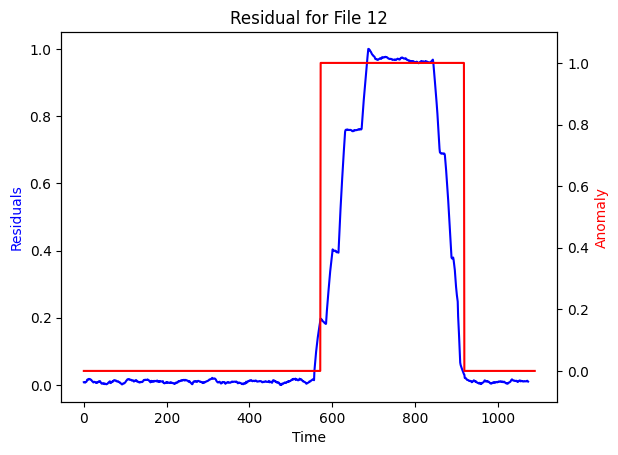

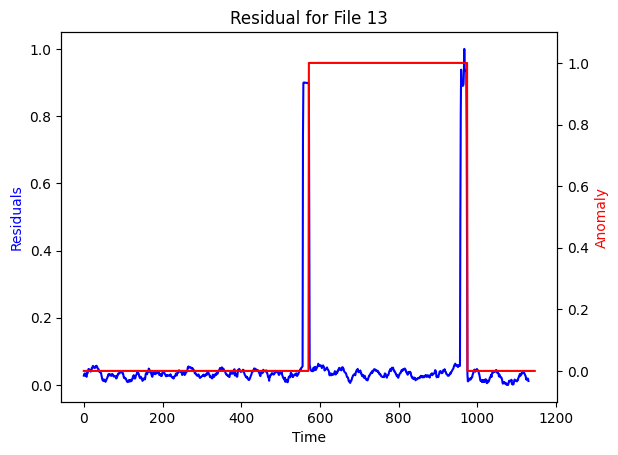

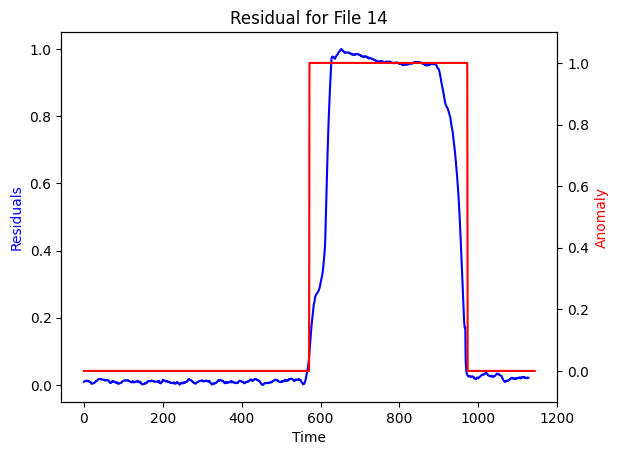

In [20]:
for i in range(len(residual_tmp_all)):
    fig, ax1 = plt.subplots()  # Create a new figure and axis for residuals

    ax1.plot(residual_tmp_all[i], 'b-')
    ax1.set_title(f'Residual for File {i+1}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Residuals', color='b')

    ax2 = ax1.twinx()  # Create a second y-axis
    ax2.plot(tmp_anom_list[i], 'r-')
    ax2.set_ylabel('Anomaly', color='r')
    ax2.set_ylim(-0.1, 1.1)  # Set limits for the anomaly axis

    plt.show()

In [21]:
preds.shape

(14705,)

In [22]:
 # metrics
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

def  f1_score(true, pred):
    return metrics.f1_score(true, pred)

def recall_score(true, pred):
    return metrics.recall_score(true, pred)

def auc_score(true, pred):
    return metrics.roc_auc_score(true, pred)

def fpr_score(true, pred):
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    # print(c.shape)
    # FP = c.sum(axis=0) - np.diag(c)  
    # FN = c.sum(axis=1) - np.diag(c)
    # TP = np.diag(c)
    # TN = c.sum() - (FP + FN + TP)

    return fp/(fp+tn)

for i, fun in enumerate([f1_score, fpr_score, recall_score, auc_score]):
    print()
    print(['f1_score', 'fpr_score', 'recall_score', 'auc_score'][i])
    for f in range(1,15):
        print(fun(labels[file_number==f],preds[file_number==f]))


f1_score
0.4100327153762268
0.6689895470383275
0.5240289664252799
0.5031847133757962
0.5293737895416398
0.5244618395303327
0.48838845883180865
0.5254237288135594
0.5245258338783518
0.617817606747496
0.5550769230769231
0.4608501118568233
0.4522184300341297
0.507136859781696

fpr_score
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0

recall_score
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0

auc_score
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
